# Amazon stock price prediction using neural networks (RNN-LSTM)

Author: Luis Fernando Salazar S. Date: 02/10/2021

In [1]:
## Import libraries
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
from colorsetup import colors, palette
plt.style.use('ggplot')
sns.set_palette(palette)
import pandas as pd
import yfinance as yf
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout, GRU, Bidirectional, Conv1D, BatchNormalization
from tensorflow.keras.metrics import mean_absolute_error

## Load Amazon Dataset

- yfinance API

In [2]:
##Get the Ticke of the stock 
amazon = yf.Ticker('AMZN')

In [3]:
## Period of cotization (2019-01-02 to 2021-10-01)
start = datetime(2019,1,1)
amazon = amazon.history(start = start)

## Exploratory data analysis (EDA)

In [4]:
## Overview information
amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 694 entries, 2019-01-02 to 2021-10-01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          694 non-null    float64
 1   High          694 non-null    float64
 2   Low           694 non-null    float64
 3   Close         694 non-null    float64
 4   Volume        694 non-null    int64  
 5   Dividends     694 non-null    int64  
 6   Stock Splits  694 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 43.4 KB


In [5]:
## Overview information
amazon.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,7983100,0,0
2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,6975600,0,0
2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,9182600,0,0
2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,7993200,0,0
2019-01-08,1664.689941,1676.609985,1616.609985,1656.579956,8881400,0,0


In [6]:
### Dimensions
print('Data dimension is{}'.format(amazon.shape))

Data dimension is(694, 7)


In [7]:
## copy
amazon_share_price = amazon.copy()

In [8]:
## Removing unnecessary data
amazon_share_price.drop(['Open','High','Low','Volume','Dividends','Stock Splits'],
                      axis=1, inplace=True)

In [9]:
## statistics summary  of the time series
amazon_share_price.describe()

,Close
count,694.000000
mean,2530.262172
std,704.408025
min,1500.280029
25%,1823.250000
50%,2416.125000
75%,3215.510010
max,3731.409912


In [ ]:
## Histogram with kenerl density
sns.histplot(data=amazon_share_price, x="Close", kde=True)

### Amazon stock close prices plots

- Firts plot: close prices from 2019 to 2021
- Second plot: close prices in 2021
- Third plot: close prices in the last 5 days

Text(0, 0.5, 'Close Prices(US$)')

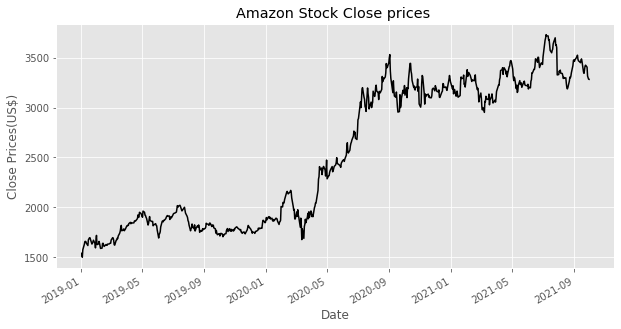

In [10]:
amazon_share_price['Close'].plot(figsize=(10,5), color ='black')
plt.title('Amazon Stock Close prices ')
plt.xlabel('Date')
plt.ylabel('Close Prices(US$)')

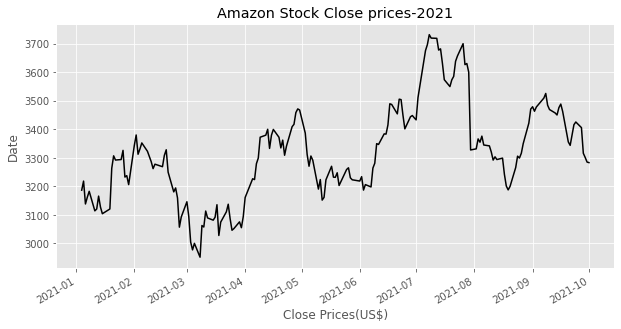

In [11]:
amazon_share_price.loc['2021', 'Close'].plot(kind='line',figsize=(10,5), color ='black')
plt.title ('Amazon Stock Close prices-2021')
plt.ylabel('Date')
plt.xlabel('Close Prices(US$)')

plt.show()

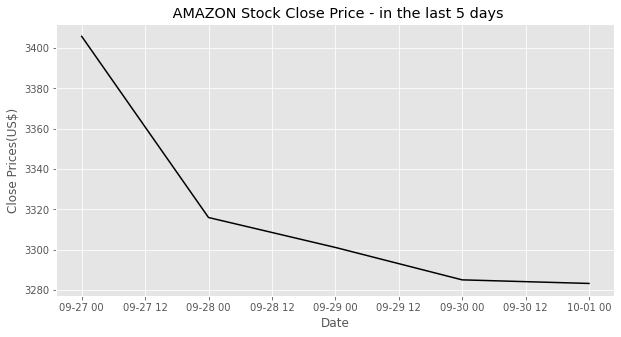

In [12]:
### 
n_days = 5 
plt.figure(figsize=(10,5))   
plt.plot((amazon_share_price['Close'][-n_days:]), 'k-')
plt.title(' {} Stock Close Price - in the last {} days'.format('AMAZON',n_days))
plt.xlabel('Date')
plt.ylabel('Close Prices(US$)')
plt.grid(alpha=1)

In [13]:
## Identify missing values
amazon_share_price.isnull().sum()

Close    0
dtype: int64

### Data preprocessing 

- Scaling data using MinMaxScaler
- Split data into train and test 
  - 80% trining and 20% tets 
- Preparate data to chart

In [ ]:
## Scaling series
from sklearn.preprocessing import MinMaxScaler
##
Mm = MinMaxScaler(feature_range = (0, 1))
##
amazon_share_price_mm = Mm.fit_transform(np.array(amazon_share_price)).reshape(-1,1)

In [15]:
## Change dimensionality of the data (target shape(batch_size, timestep, features)) 
def get_format_series(series):
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1],1)

## Train set

def train_tets_split(n_days, test_days,sample_gap=2):
    
    # reducing our forecast series to last n days
    forecast_series = amazon_share_price_mm 
    
    # training data is remaining days until amount of test_days
    train = forecast_series[:-test_days] 
    # test data is the remaining test_days
    test = forecast_series[-test_days:]
    
    ## Train
    X_train,y_train = [],[]

    for i in range(0,train.shape[0]-n_days,sample_gap):  
        # each training sample is of length input days
        X_train.append(train[i:i+n_days])   
        # each y is just the next step after training sample
        y_train.append(train[i])
    
    X_train = get_format_series(X_train)
    y_train = np.array(y_train)
    
    
    ## Test 
    X_test,y_test = [],[]

    for i in range(0,test.shape[0]-n_days):  
        X_test.append(test[i:i+n_days])   
        y_test.append(test[i])            

    X_test = get_format_series(X_test)
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test

In [16]:
test_days = round(len(amazon_share_price)*0.2)
###
X_train, X_test, y_train, y_test = (train_tets_split(n_days,test_days))

In [17]:
## Training and test data dimension
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (275, 5, 1)
Training output shape: (275, 1)
Test input shape: (134, 5, 1)
Test output shape: (134, 1)


In [18]:
### Preparate data to chart
df_train = amazon_share_price[:-test_days+n_days] 
df_test = amazon_share_price[-test_days:-n_days].copy()

## Neural network model 

- RNN-LSTM architecture, alongside convolutional (1D) and dense layers
- compile model
- Training model
- Prediction 
- Model performance evaluation
- Save the model

In [19]:
## Model
def LSTM_model():
    
    input_ = Input(shape=(X_train.shape[1],1))
    
    x = Conv1D(filters = 100, kernel_size =5,
              strides =1, padding='causal', activation='relu')(input_)
    x = BatchNormalization()(x)
    x = LSTM(250, return_sequences = True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(250, return_sequences = True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(250)(x)
    x = Dropout(0.2)(x)
    x = Dense(100)(x)
    x = Dropout(0.5)(x)
    output = Dense(1)(x)
    
    model = Model(inputs = input_, outputs = output, name = 'LSTM_model')
    
    return model

In [20]:
##
model = LSTM_model()
##
model.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 5, 100)            600       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 100)            400       
_________________________________________________________________
lstm (LSTM)                  (None, 5, 250)            351000    
_________________________________________________________________
dropout (Dropout)            (None, 5, 250)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 250)            501000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 250)            0

In [21]:
## Compile the model
model.compile(loss = 'mse', optimizer = 'adam')

In [22]:
## Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=300, mode='max')

### Training model

In [23]:
hist_lstm = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                      batch_size = 32,
                      epochs = 5000, verbose = 0, callbacks = [lr_reduce])

### Prediction

-Forecast plot

In [24]:
##
y_predict_lstm = model.predict(X_test)
y_predict_lstm =  Mm.inverse_transform(y_predict_lstm)

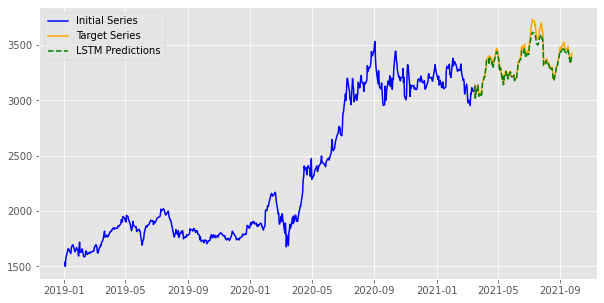

In [25]:
## chart of the Forecast
plt.figure(figsize=(10,5)) 
df_test['Predict_LSTM'] = y_predict_lstm  
plt.plot(df_train['Close'],color='blue',label='Initial Series')
plt.plot(df_test['Close'],color='orange',label='Target Series')
plt.plot(df_test['Predict_LSTM'],color='green',linestyle='dashed',label='LSTM Predictions'
)
plt.legend()
plt.grid(True)
plt.show()

### Model performance evaluation
- Loss and validation plot 

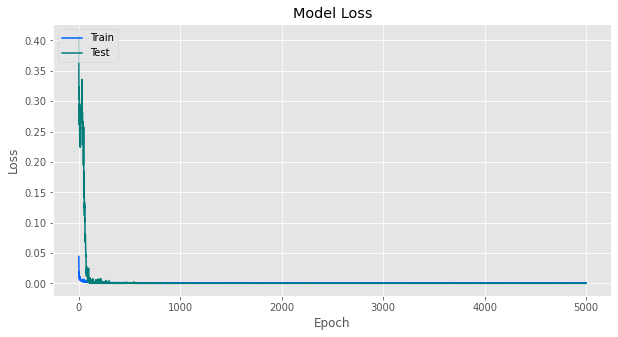

In [26]:
# Loss History
plt.figure(figsize=(10,5))
plt.plot(hist_lstm.history['loss'])
plt.plot(hist_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Observations.

-According to the model loss plot, the model shows a great performance fitting (there is no presence of overfitting) and generalizing (see prediction plot) the Amazon stock close prices.

### Save model

In [ ]:
model_save_path = ".../Models"
tf.saved_model.save(model, model_save_path)